# High behavioral variability during naturalistic movements

Load in the computed spectral power (TFR) data and extracts the saved x,y positions of the wrists during movement. This data is plotted to show the high variability of the detected arm movements and the increased displacement in the contralateral wrist relative to the ipsilateral. This will generate Fig. 2 from the paper.

In [1]:
%matplotlib inline
import glob, natsort, mne, sys, pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mne.time_frequency import read_tfrs
import config

### Set parameters

In [2]:
tfr_lp = '/data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/'
n_rand_traces_plt = 100
n_subjs = 12

### Load in subject 01 metadata for displacement plot 

Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_3_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_4_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_5_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_7_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns


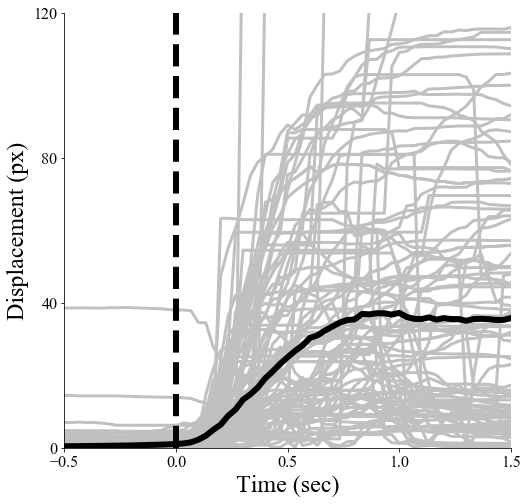

In [3]:
fnames_all = natsort.natsorted(glob.glob(tfr_lp+'subj_01*.h5'))

for s,fname in enumerate(fnames_all):
    wrist = fname.split('_')[-3]
    #Load in metadata
    power = read_tfrs(fname)[0]
    contra_metadata = power.metadata.loc[:,[wrist+'_wrist_x',wrist+'_wrist_y']]
    del power
    
    #Append to 1 dataframe
    if s==0:
        contra_metadata_s01 = contra_metadata.copy()
    else:
        contra_metadata_s01 = pd.concat((contra_metadata_s01,contra_metadata),ignore_index=True)
        
#Compute baseline-subtracted displacement
wrist_x = contra_metadata_s01.loc[:,wrist+'_wrist_x']
wrist_x = [np.asarray(val) for val in wrist_x]
wrist_y = contra_metadata_s01.loc[:,wrist+'_wrist_y']
wrist_y = [np.asarray(val) for val in wrist_y]
contra_vals = np.sqrt(np.asarray(wrist_x)**2 +np.asarray(wrist_y)**2)

#Determine baseline in samples
min_t_val = config.metadata_pos_min_time
base_times = np.asarray(config.baseline_vals_movement)
base_times = (base_times-min_t_val)*config.fs_video #baseline frame limits
base_times_range = np.arange(base_times[0],base_times[1]+1)
base_times_range = base_times_range.astype('int')

#Subtract baseline from position data
contra_vals_basesub = contra_vals.copy()
for i in range(contra_vals_basesub.shape[0]):
    curr_magnitude = contra_vals[i,:]
    contra_vals_basesub[i,:] = np.abs(curr_magnitude - np.mean(curr_magnitude[base_times_range]))
    
#Plot 100 random traces
fig,ax = plt.subplots(1,1,figsize=(8,8))
t = (np.arange(contra_vals_basesub.shape[1])/config.fs_video)+min_t_val
rand_inds_all = []
for i in range(n_rand_traces_plt):
    rand_ind = np.random.randint(contra_vals_basesub.shape[0])
    rand_inds_all.append(rand_ind)
    ax.plot(t,contra_vals_basesub[rand_ind,:],color='silver',linewidth=3,alpha=1)
ax.plot(t,np.median(contra_vals_basesub,axis=0),color='k',linewidth=6)
ax.set_xlim([-0.5,1.5])
ax.set_ylim([0,120])
ax.set_ylabel('Displacement (px)',fontsize=24,fontweight='normal', fontname='Times New Roman') #Distance (px)
ax.set_xlabel('Time (sec)',fontsize=24,fontweight='normal', fontname='Times New Roman') #Time (sec)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks([-0.5,0,0.5,1,1.5])
ax.set_yticks([0,40,80,120])
plt.setp(ax.get_xticklabels(), fontsize=16, fontweight="normal", fontname='Times New Roman')
plt.setp(ax.get_yticklabels(), fontsize=16, fontweight="normal", fontname='Times New Roman')
plt.axvline(0, linewidth=6, color="black", linestyle="--")
plt.show()

# Movement displacements for contralateral and ipsilateral wrist movement

In [4]:
for i in range(n_subjs):
    fnames_all = natsort.natsorted(glob.glob(tfr_lp+'subj_'+str(i+1).zfill(2)+'*.h5'))

    for s,fname in enumerate(fnames_all):
        wrist_contra = fname.split('_')[-3]
        wrist_ipsi = 'l' if wrist_contra == 'r' else 'r' #set ipsilateral wrist
        #Load in metadata
        power = read_tfrs(fname)[0]
        contra_metadata = power.metadata.loc[:,[wrist_contra+'_wrist_x',wrist_contra+'_wrist_y']]
        ipsi_metadata = power.metadata.loc[:,[wrist_ipsi+'_wrist_x',wrist_ipsi+'_wrist_y']]
        del power
        
        #Append to 1 dataframe
        if s==0:
            contra_metadata_sbj = contra_metadata.copy()
            ipsi_metadata_sbj = ipsi_metadata.copy()
        else:
            contra_metadata_sbj = pd.concat((contra_metadata_sbj,contra_metadata),ignore_index=True)
            ipsi_metadata_sbj = pd.concat((ipsi_metadata_sbj,ipsi_metadata),ignore_index=True)
            
    #Compute baseline-subtracted displacement
    wrist_x = contra_metadata_sbj.loc[:,wrist_contra+'_wrist_x']
    wrist_x = [np.asarray(val) for val in wrist_x]
    wrist_y = contra_metadata_sbj.loc[:,wrist_contra+'_wrist_y']
    wrist_y = [np.asarray(val) for val in wrist_y]
    contra_vals = np.sqrt(np.asarray(wrist_x)**2 +np.asarray(wrist_y)**2)
    
    wrist_x = ipsi_metadata_sbj.loc[:,wrist_ipsi+'_wrist_x']
    wrist_x = [np.asarray(val) for val in wrist_x]
    wrist_y = ipsi_metadata_sbj.loc[:,wrist_ipsi+'_wrist_y']
    wrist_y = [np.asarray(val) for val in wrist_y]
    ipsi_vals = np.sqrt(np.asarray(wrist_x)**2 +np.asarray(wrist_y)**2)

    #Determine baseline in samples
    min_t_val = config.metadata_pos_min_time
    base_times = np.asarray(config.baseline_vals_movement)
    base_times = (base_times-min_t_val)*config.fs_video #baseline frame limits
    base_times_range = np.arange(base_times[0],base_times[1]+1)
    base_times_range = base_times_range.astype('int')

    #Subtract baseline from position data
    contra_vals_basesub = contra_vals.copy()
    ipsi_vals_basesub = ipsi_vals.copy()
    for j in range(contra_vals_basesub.shape[0]):
        curr_magnitude = contra_vals[j,:]
        contra_vals_basesub[j,:] = np.abs(curr_magnitude - np.mean(curr_magnitude[base_times_range]))
        curr_magnitude_ipsi = ipsi_vals[j,:]
        ipsi_vals_basesub[j,:] = np.abs(curr_magnitude_ipsi - np.mean(curr_magnitude_ipsi[base_times_range]))
    
    if i==0:
        contra_metadata_all = np.median(contra_vals_basesub,axis=0,keepdims=True)
        ipsi_metadata_all = np.median(ipsi_vals_basesub,axis=0,keepdims=True)
    else:
        contra_metadata_all = np.concatenate((contra_metadata_all,np.median(contra_vals_basesub,axis=0,keepdims=True)),axis=0)
        ipsi_metadata_all = np.concatenate((ipsi_metadata_all,np.median(ipsi_vals_basesub,axis=0,keepdims=True)),axis=0)

Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_3_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_4_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_5_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_7_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_02_day_3_l_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_02_day_4_l_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_02_day_5_l_allEpochs_tfr.h5 ...
Add

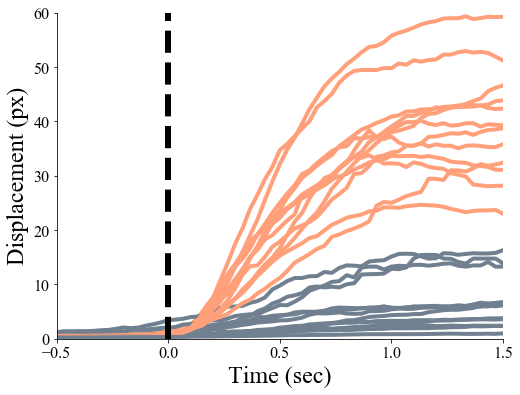

In [5]:
#Create time variable for plotting
df_tmp = pd.DataFrame(contra_metadata_all).melt()
df_tmp["variable"] = (df_tmp["variable"]/config.fs_video)+min_t_val
var_vals = df_tmp["variable"].unique()
del df_tmp

#Plot traces
fig,ax = plt.subplots(1,1,figsize=(8,6))
for i in range(contra_metadata_all.shape[0]):
    df_contra_wrist_all = pd.DataFrame(contra_metadata_all[i,:]).melt()
    df_contra_wrist_all["variable"] = var_vals
    df_ipsi_wrist_all = pd.DataFrame(ipsi_metadata_all[i,:]).melt()#pd.DataFrame(lh_wrist_all).melt()
    df_ipsi_wrist_all["variable"] = var_vals

    sns.lineplot(x="variable",y="value",data=df_contra_wrist_all,ax=ax,
                 linewidth=4,estimator=None,color='lightsalmon')
    sns.lineplot(x="variable",y="value",data=df_ipsi_wrist_all,ax=ax,
                 linewidth=4,estimator=None,color='slategray')

ax.set_ylim([0,60])
ax.set_xlim([-0.5,1.5])
ax.set_xticks([-0.5,0,0.5,1,1.5])
plt.setp(ax.get_yticklabels(), fontsize=16, fontweight="normal",fontname='Times New Roman')
plt.setp(ax.get_xticklabels(), fontsize=16, fontweight="normal",fontname='Times New Roman')
ax.set_ylabel('Displacement (px)',fontsize=24,fontweight='normal',fontname='Times New Roman') #Displacement (px)
ax.set_xlabel('Time (sec)',fontsize=24,fontweight='normal',fontname='Times New Roman') #Time (sec)
sns.set_style("ticks")
sns.despine()
plt.axvline(0, linewidth=6, color="black", linestyle="--")
plt.show()